# Brain-Inspired Digital System

This project simulates brain activity using EEG signals and spiking neural networks (SNNs)

-Let's imagine: The human brain transmits information through electrical potential changes between neurons. These biopotential signals can be measured by electrodes placed on the scalp, and this process is called Electroencephalography (EEG).

-The EEG device collects low-amplitude electrical signals resulting from cortical neuronal activity in the form of a time series. These signals are typically analog and multivariate, containing different rhythms in the frequency spectrum, such as delta, theta, alpha, beta and gamma.

**Spiking Neural Network (SNN)** is a type of artificial neural network that mimics the electrical firing behavior (spikes) of biological neurons in real time.

In [44]:
import mne

data_path = mne.datasets.sample.data_path()
from pathlib import Path

# this dataset contains both MEG and EEG data and is the trial data that comes with the MNE.
raw_file = Path(data_path) / 'MEG' / 'sample' / 'sample_audvis_raw.fif' # using the data_path obtained above, we create the full path to the .fif file containing the EEG data. 📁 This file contains the EEG/MEG data collected during the auditory/visual stimulus.

raw = mne.io.read_raw_fif(raw_file, preload=True) # we load the data in the file we specified into an MNE object named raw.
raw.pick_types(eeg=True)
raw.crop(tmax=30)

"""
This EEG signal is band-pass filtered between 1 Hz and 40 Hz
Signals below 1 Hz (e.g. movement artifacts) are generally noise.
Signals above 40 Hz (e.g. muscle movement) are generally considered noise.
This range generally includes brain waves (delta, theta, alpha, beta).
"""
    
raw.filter(1., 40., fir_design='firwin') # → The filter is a FIR filter designed in time domain. (More stable and reliable.)

data, times = raw[:32, :]  # The reason for choosing 32 channels is to obtain a subset of signals that adequately represents different regions of the brain and to keep the processing time reasonable.
print(data.shape)


Opening raw data file /Users/handanvural/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1983 samples (3.302 s)

(

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


**Purpose**:
→ To visually compare the EEG signal before filtering (noisy) and after filtering (cleaned) in the time axis.

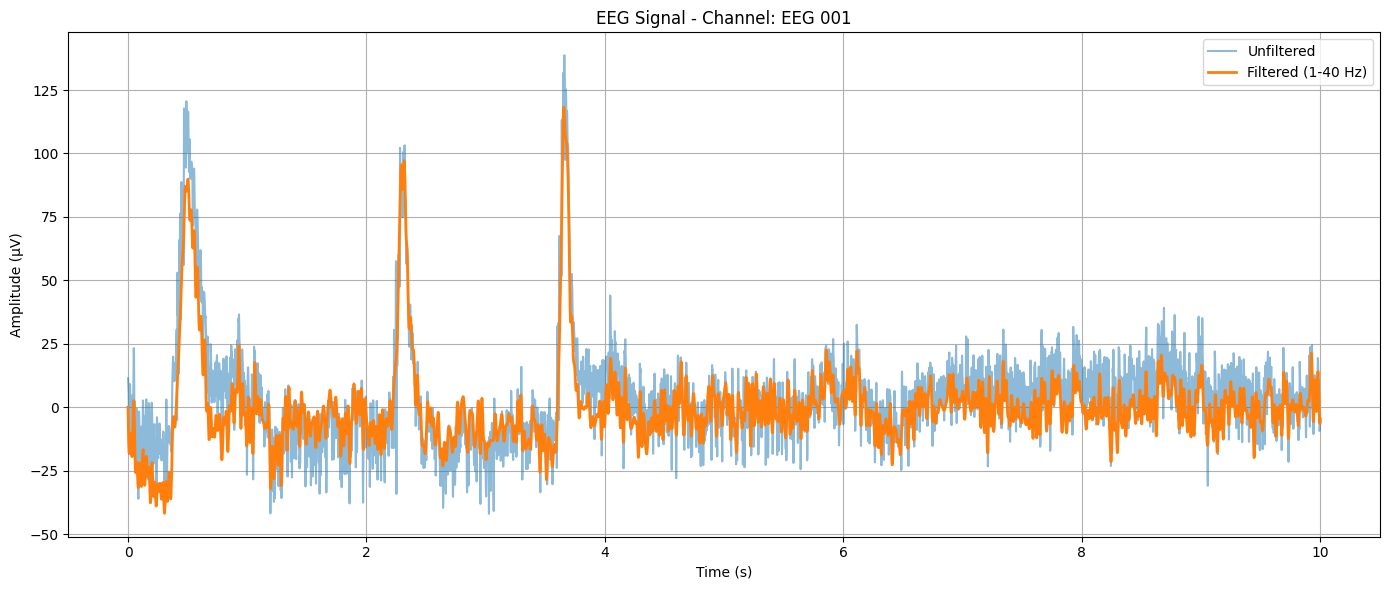

In [45]:
# we select the EEG channel index to analyze (here, index 0 — usually “Fp1”), and fetch its name from the metadata.
channel_index = 0
channel_name = raw.info['ch_names'][channel_index]

# we extract the signal of the selected channel from both the unfiltered and filtered data. times provides the time points (in seconds) of the samples.
unfiltered_data, times = raw_unfiltered[channel_index, :]
filtered_data, _ = raw[channel_index, :]

# EEG signals are often in volts, so we convert them to microvolts (µV) by multiplying by 1e6.
unfiltered_data *= 1e6
filtered_data *= 1e6

# we create a mask to only analyze the first 10 seconds of the signal
time_mask = (times >= 0) & (times <= 10)
t = times[time_mask]
unf = unfiltered_data[0][time_mask]
filt = filtered_data[0][time_mask]

# Çizim
plt.figure(figsize=(14, 6))
plt.plot(t, unf, label='Unfiltered', alpha=0.5)
plt.plot(t, filt, label='Filtered (1-40 Hz)', linewidth=2)
plt.title(f"EEG Signal - Channel: {channel_name}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Purpose**:
Which frequency components are strong in the EEG signal?
To see this, we calculate and plot PSD (Power Spectral Density) with the Welch method.

**PSD is calculated with the Welch method**:
eeg_signal: analyzed signal
sfreq: sampling frequency
nperseg=1024: use 1024 samples in each segment (for smoother spectrum)
The Welch method gives a smoother and more reliable spectrum by splitting the signal into parts and averaging them.

- It analyzes the frequency components in the EEG signal according to their strength and produces a spectrum. Noise control is a fundamental step for brain wave detection and mood analysis.

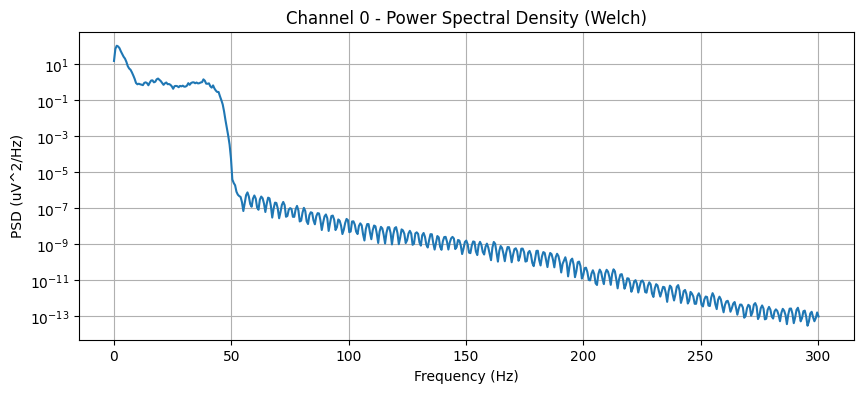

In [46]:
import matplotlib.pyplot as plt
from scipy.signal import welch

channel_index = 0 # Selects the 0th EEG channel and converts the signal to microvolts (µV).
eeg_signal = data[channel_index] * 1e6  

sfreq = raw.info['sfreq'] # Gets the EEG data’s sampling frequency.

# PSD (Welch)
freqs, psd = welch(eeg_signal, sfreq, nperseg=1024)

plt.figure(figsize=(10, 4))
plt.semilogy(freqs, psd)
plt.title(f'Channel {channel_index} - Power Spectral Density (Welch)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (uV^2/Hz)')
plt.grid(True)
plt.show()


**Purpose:**
To convert alpha power obtained from Power Spectral Density into spike train.
This forms the basis for an artificial neuron model that mimics brain activity.

**what does this do?**

These spike trains can be used as SNN (Spiking Neural Network) inputs.
If there is a real-time EEG signal, spikes can be generated to neurons instantly.
It is a powerful brain-signal → digital system bridge.

Normalized Alpha Power: 0.0099


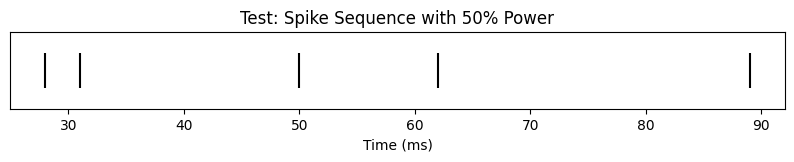

Number of spikes formed: 5


In [47]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# This function generates a rate-based spike train depending on input power.
def rate_encoding(power, max_rate=100, duration=100):
    """
    Produces spike train according to power.
    power: normalized energy between 0-1
    max_rate: maximum spike frequency (Hz)
    duration: total duration (ms)
    """
    power = np.clip(power, 0.01, 1)  # guarantee spike production
    num_spikes = int(power * max_rate * (duration / 1000))
    spike_train = np.zeros(duration)
    if num_spikes > 0:
        spike_times = np.random.choice(range(duration), num_spikes, replace=False)
        spike_train[spike_times] = 1
    return spike_train

# Normalize PSD (0 to 1)
scaler = MinMaxScaler()
psd_norm = scaler.fit_transform(psd.reshape(-1, 1)).flatten()

# Alpha band index,
# Selects the alpha band (8–13 Hz) and computes its average normalized power.
alpha_idx = np.logical_and(freqs >= 8, freqs <= 13)
normalized_alpha = np.mean(psd_norm[alpha_idx])
print(f"Normalized Alpha Power: {normalized_alpha:.4f}")

# Test: manually power up and produce spikes
test_power = 0.5  # %50 
spike_train = rate_encoding(test_power, max_rate=100, duration=100)

plt.figure(figsize=(10, 1))
plt.eventplot(np.where(spike_train == 1), colors='black')
plt.title("Test: Spike Sequence with 50% Power")
plt.xlabel("Time (ms)")
plt.yticks([])
plt.show()

print(f"Number of spikes formed: {int(test_power * 100 * (100/1000))}")


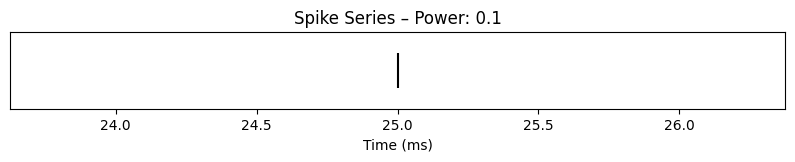

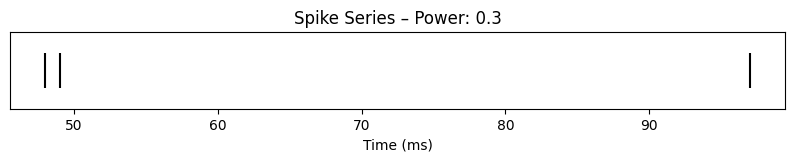

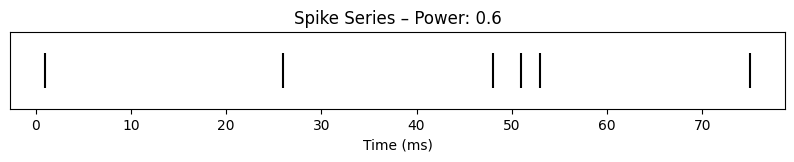

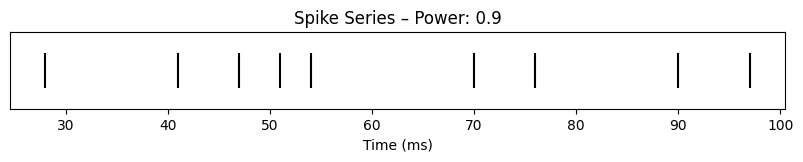

In [48]:
for p in [0.1, 0.3, 0.6, 0.9]:
    spike_train = rate_encoding(p, max_rate=100, duration=100)
    plt.figure(figsize=(10, 1))
    plt.eventplot(np.where(spike_train == 1), colors='black')
    plt.title(f"Spike Series – Power: {p}")
    plt.xlabel("Time (ms)")
    plt.yticks([])
    plt.show()

-It builds an artificial neuron system that generates spikes based on frequency information from EEG data.

**Aim:**
Generate spikes with normalized power value →
Send this spike train to an artificial neuron working with Brian2 →
Does the neuron fire or not? How often does it fire?

-Thanks to this system, the power information from the EEG has now been transformed into the behavior of an artificial neuron. If alpha power is high, more frequent spikes are produced, meaning that neuron firing behavior changes according to brain activity.

**Spike:** The moment when a real neuron sends an electrical signal.

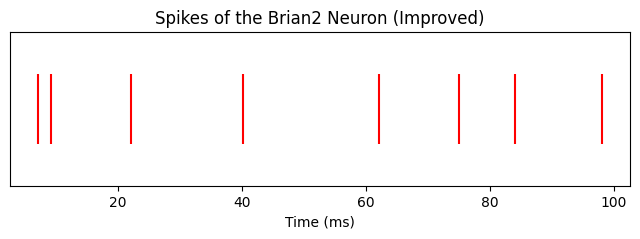

Neuron total 8 fired times.


In [51]:
from brian2 import *

# Generate spikes
test_power = 1.0
spike_train = rate_encoding(test_power, max_rate=200, duration=100)
spike_times = np.where(spike_train == 1)[0] * ms

prefs.codegen.target = 'numpy'

duration = 100 * ms

input_group = SpikeGeneratorGroup( # creates an input group that generates spikes at the specified times.
    1,
    indices=np.zeros(len(spike_times), dtype=int),
    times=spike_times
)

# defines a neuron model where membrane potential v decays over time.
eqs = ''' 
dv/dt = ( -v ) / (10*ms) : 1
'''
# defines a neuron that fires when v exceeds 0.5 and resets afterward.
neuron = NeuronGroup(1, model=eqs, threshold='v > 0.5', reset='v = 0', method='exact')

# spike → warning.
# when a spike occurs in the input, the neuron's voltage increases by 0.3.
syn = Synapses(input_group, neuron, on_pre='v += 0.3')  
syn.connect()

mon = SpikeMonitor(neuron) # a spike monitor tracks the neuron's output, and simulation is run.
run(duration)

# Grafik
plt.figure(figsize=(8, 2))
plt.eventplot(mon.t / ms, colors='red')
plt.title("Spikes of the Brian2 Neuron (Improved)")
plt.xlabel("Time (ms)")
plt.yticks([])
plt.show()

print(f"Neuron total {mon.count[0]} fired times.")
